<br>

<p style='text-align: right;'> Birkan Emrem </p>
<p style='text-align: right;'> 19.11.2025 </p>
<p style='text-align: right;'> Density Functional Tight Binding (DFTB) and Applications with DFTB+  </p>

# Density Functional Tight Binding (DFTB) and Applications with DFTB+

<hr style="border: 1.5px solid gray;">

## Introduction & Theory

- Why do we need methods faster than DFT?
- The trade-off between accuracy vs computational cost
- Where DFTB fits: „between classical force fields and full DFT“

<img src="Figures/Picture1.png" style="height:300px">

#### Ideal for:
- Large-scale molecular dynamics
- Materials discovery and screening
- Studying reactivity in complex systems

<hr style="border: 1.5px solid gray;">

## Theoretical Background — DFTB

Density Functional Tight-Binding (DFTB):
- A computationally efficient approximation to DFT
- Ideal for large systems (biomolecules, MD simulations)

<img src="Figures/Picture2.png" style="height:200px">

$$
{\huge  E_{DFTB} = E_{BS} + E_{coul} + E_{rep}}
$$

- ${\large E_{DFTB}}$ -->  DFTB total energy
- ${\large E_{BS}}$ -->    Band structure energy
- ${\large E_{coul}}$-->   Coulomb interaction
- ${\large E_{rep}}$-->    Repulsive energy 

<hr style="border: 1.5px solid gray;">

## Input and Output Files

**Geometry File (`.gen`)**

<pre style="background-color: #f6f6f6">
5  C    
H  C    
  1 1  0.528800  0.161000  0.93590
  2 2  0.000000  0.000000  0.00000
  3 1  0.205100  0.824000  0.67860
  4 1  0.334500 -0.931400 -0.44960
  5 1 -1.068500 -0.053700  0.19210
</pre>

**Input File (`dftb_in.hsd`)**

<pre style="background-color: #f6f6f6">
Geometry = GenFormat {
   <<< "methane.gen"
}

Hamiltonian = DFTB {
  SCC = Yes
  SlaterKosterFiles {
     H-H = "../../../../H-H.skf"
     C-H = "../../../../C-H.skf"  
     H-C = "../../../../H-C.skf" 
     C-C = "../../../../C-C.skf"
}
MaxAngularMomentum {
     C = "p"  
     H = "s"
  }
} 
</pre>

<hr style="border: 1.5px solid gray;">

**Output Files**

<pre style="background-color: #f6f6f6">
detailed.out # Full calculation log
*.out.gen # Final geometry in GEN
*.out.xyz # Final geometry in XYZ
charges.bin # Mulliken charges
band.out #band/DOS
</pre>

#### Goals of This Hands-on
- Perform 4 types of calculations using 4 different representative systems
- Build and run all simulations from a parent Jupyter notebook
- Visualize and analyze results interactively
#### Tools and dependencies
- DFTB+, ASE, NGLView, NumPy, Matplotlib, OS tools

In [2]:
import os
from ase import Atoms
from ase.visualize import view
from ase.io import read
import nglview as nv

<hr style="border: 1.5px solid gray;">

## Geometry Optimization

### Triglucose substrate

In [3]:
structure_1 = read("structures/all4-1_0.gen")
w = nv.show_ase(structure_1)
w.clear_representations()
w.add_ball_and_stick(radius=0.3)
w

NGLWidget()

### Create Directory for the Calculations

In [4]:
! pwd

/home/di97fod/Desktop/courses/BioPhy


In [5]:
! mkdir calculations               # create the parent directory for the calculations
! mkdir calculations/GO            # create the GO directory for the geometry optimzation

Navigate to directory for the geometry optimization

In [6]:
%cd calculations/GO/

/home/di97fod/Desktop/courses/BioPhy/calculations/GO


In [7]:
%%writefile dftb_in.hsd

Geometry = GenFormat {
    <<< "../../structures/all4-1_0.gen"
}
Hamiltonian = DFTB {
    SCC = Yes
    ThirdOrderFull = Yes
    HubbardDerivs {
        H = -0.1857
        C = -0.1492
        O = -0.1575
    }
    Mixer = Broyden {
        MixingParameter = 0.1
    }
    MaxSCCIterations = 300
    SlaterKosterFiles = Type2FileNames {
        Prefix = "../../parameters/3ob-3-1/"
        Separator = "-"
        Suffix = ".skf"
    }
MaxAngularMomentum {
    H = s
    C = p
    O = p
}
}
Driver = GeometryOptimization {
  Optimizer = Rational {}
  MovedAtoms = 1:-1               # Move all atoms in the system
  MaxSteps = 200                  # Stop after maximal 100 steps
  OutputPrefix = "geom.out"       # Final geometry in geom.out.{xyz,gen}
  Convergence {GradElem = 0.001}   # Stop if maximal force below 1E-4 H/a0
}

Writing dftb_in.hsd


<hr style="border: 1.5px solid gray;">

In [8]:
# Run calculation
! dftb+ > triglucose.log

check the directory

In [9]:
! ls

band.out     detailed.out  dftb_pin.hsd  geom.out.xyz
charges.bin  dftb_in.hsd   geom.out.gen  triglucose.log


control the log file

In [10]:
! cat triglucose.log

|===============================================================================
|
|  DFTB+ release 24.1
|
|  Copyright (C) 2006 - 2024  DFTB+ developers group
|
|===============================================================================
|
|  When publishing results obtained with DFTB+, please cite the following
|  reference:
|
|  * DFTB+, a software package for efficient approximate density functional
|    theory based atomistic simulations, J. Chem. Phys. 152, 124101 (2020).
|    [doi: 10.1063/1.5143190]
|
|  You should also cite additional publications crediting the parametrization
|  data you use. Please consult the documentation of the SK-files for the
|  references.
|
|===============================================================================

Reading input file 'dftb_in.hsd'
Parser version: 14

--------------------------------------------------------------------------------
Reading SK-files:
../../parameters/3ob-3-1/O-O.skf
../../parameters/3ob-3-1/O-C.skf
../../parame

extract total energies and save into `energies.txt`

In [11]:
! grep "Total Energy" triglucose.log | awk '{print $3}' > energies.txt

control the `energies.txt` file

In [12]:
! cat energies.txt

-87.9747853308
-88.1581573048
-88.3235456743
-88.4316353471
-88.5013513975
-88.5482347574
-88.5625706362
-88.5789474435
-88.5968777061
-88.6102477586
-88.6201866302
-88.6288930780
-88.6379873743
-88.6476927353
-88.6560485807
-88.6625237480
-88.6680723314
-88.6730849031
-88.6769504591
-88.6810591469
-88.6856896165
-88.6903631667
-88.6946941495
-88.6986706242
-88.7020526715
-88.7058011101
-88.7091302959
-88.7128142885
-88.7143169895
-88.7160181582
-88.7178449323
-88.7202767369
-88.7225640991
-88.7245220514
-88.7262766896
-88.7282698737
-88.7302763411
-88.7323586723
-88.7344823491
-88.7369786934
-88.7392424354
-88.7410547666
-88.7422816963
-88.7435016512
-88.7446506347
-88.7458630953
-88.7470264941
-88.7482867090
-88.7496830093
-88.7510988065
-88.7522437367
-88.7530285573
-88.7536084405
-88.7540961599
-88.7546236208
-88.7552189162
-88.7559503049
-88.7566337861
-88.7572587537
-88.7579383741
-88.7587075491
-88.7594413840
-88.7600598857
-88.7605875052
-88.7611542346
-88.7617149360
-88.762176

plot the total and relative energy with respect to geometry steps

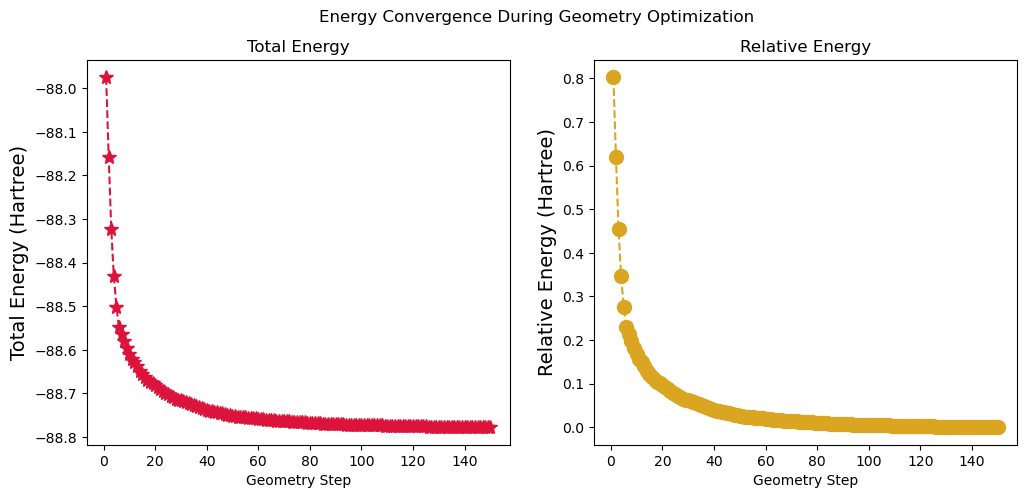

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Read the log file
with open("triglucose.log", "r") as f:
    lines = f.readlines()

#energy values
energies = pd.read_csv("energies.txt", header=None)
energy_diff = [i - min(energies[0]) for i in energies[0]]


# Plotting
ax1.plot(range(1, len(energies) + 1), energies, marker='*', color='crimson', markersize=10, linestyle='--')
ax1.set_xlabel("Geometry Step")
ax1.set_ylabel("Total Energy (Hartree)", fontsize=14)
ax1.set_title("Total Energy")

ax2.plot(range(1, len(energies) + 1), energy_diff, marker='o', color='goldenrod', markersize=10, linestyle='--')
ax2.set_xlabel("Geometry Step")
ax2.set_ylabel("Relative Energy (Hartree)", fontsize=14)
ax2.set_title("Relative Energy")

_ = fig.suptitle("Energy Convergence During Geometry Optimization")

Now let's look at how the optimized geometry looks

In [14]:
structure_1_opt = read("geom.out.gen")
w2 = nv.show_ase(structure_1_opt)
w2.clear_representations()
w2.add_ball_and_stick(radius=0.3)
w2

NGLWidget()

<hr style="border: 1.5px solid gray;">

## HOMO-LUMO GAP

### Triangular Finite $Mo_aS_b$ Nanoparticle

In this section we are going to investigate finite $Mo_{28}S_{72}$ nanoparticle.

In [15]:
structure_2 = read("../../structures/MoS2_triangle.gen")
w = nv.show_ase(structure_2)
w.clear_representations()
w.add_ball_and_stick(radius=0.5)
w

NGLWidget()

first lets go back to main directory

In [16]:
%cd ../..

/home/di97fod/Desktop/courses/BioPhy


In [17]:
! ls

calculations  dftb.ipynb  dos.py  Figures  parameters  structures


and let's create a directory named `homo_lumo_gap` where we will perform this calculation

In [18]:
! mkdir calculations/homo_lumo_gap     # create the homo-lumo-gap directory

In [19]:
%cd calculations/homo_lumo_gap

/home/di97fod/Desktop/courses/BioPhy/calculations/homo_lumo_gap


now we write our input file and save as `dftb_in.hsd`

In [20]:
%%writefile dftb_in.hsd

Geometry = GenFormat {
    <<< "../../structures/MoS2_triangle.gen"
}

Hamiltonian = DFTB {
    SCC = Yes
    SCCTolerance = 1e-5
    MaxSCCIterations = 1000
    SlaterKosterFiles = Type2FileNames {
        Prefix = "../../parameters/ptbp/"
        Separator = "-"
        Suffix = ".skf"
    }
MaxAngularMomentum {
    Mo = "d"
    S = "p"
}
Charge = 0
Filling = Fermi {
    Temperature [Kelvin] = 300
}
}

Analysis = {
    WriteEigenvectors = Yes
}
Options {
    WriteDetailedXml = Yes
    WriteResultsTag = Yes
}

ParserOptions {
    ParserVersion = 14
}

Writing dftb_in.hsd


We run the calculation

In [21]:
! dftb+ > MoS2_triangle.log

Now we use simple python script to extract HOMO, LUMO and Gap values in eV

In [22]:
homo = None
lumo = None

with open("band.out") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 3:
            continue # skip bad lines
        ev = float(parts[1])
        occ = float(parts[2])
        if occ > 1e-3:
            homo = ev # keep updating until last occupied
        elif lumo is None:
            lumo = ev # first unoccupied eigenvalue

if homo is not None and lumo is not None:
    print(f"HOMO: {homo:.3f} eV")
    print(f"LUMO: {lumo:.3f} eV")
    print(f"Gap : {lumo - homo:.3f} eV")
else:
    print("Could not find HOMO or LUMO.")

HOMO: -6.155 eV
LUMO: -5.551 eV
Gap : 0.604 eV


<hr style="border: 1.5px solid gray;">

## Density of States and Bandstructure

### Graphene: 4x4x1 Supercell

In this section we are going to investigate density of states and electronic band structure of 4x4 supercell graphene monolayer
<br>
Let's first look how our monolayer looks

In [23]:
structure_3 = read("../../structures/graphene_441.gen")
w = nv.show_ase(structure_3)
w.clear_representations()
w.add_ball_and_stick(radius=0.35)
w

NGLWidget()

we go one directory back and create a directory for this section

In [25]:
%cd ..

/home/di97fod/Desktop/courses/BioPhy/calculations


In [26]:
! mkdir dos_bs

In [27]:
%cd dos_bs/

/home/di97fod/Desktop/courses/BioPhy/calculations/dos_bs


Firstly we are going to optimize the monolayer, and let's create a directory for that

In [28]:
!mkdir GO
%cd GO

/home/di97fod/Desktop/courses/BioPhy/calculations/dos_bs/GO


In [29]:
%%writefile dftb_in.hsd

Geometry = GenFormat {
    <<< "../../../structures/graphene_441.gen"
}

Hamiltonian = DFTB {
    SCC = Yes
    MaxSCCIterations = 300
    SlaterKosterFiles = Type2FileNames {
        Prefix = "../../../parameters/mio-1-1/"
        Separator = "-"
        Suffix = ".skf"
    }
MaxAngularMomentum {
    C = "p"
}
KPointsAndWeights = SupercellFolding {
  24 0 0
  0 24 0
  0 0 1
  0.0 0.0 0.0
}
Filling = Fermi {
  Temperature [Kelvin] = 100
}
}

Driver = GeometryOptimization {
  Optimizer = Rational {}
  LatticeOpt = Yes
  Isotropic = Yes
  MovedAtoms = 1:-1               # Move all atoms in the system
  MaxSteps = 200                  # Stop after maximal 100 steps
  OutputPrefix = "geom.out"       # Final geometry in geom.out.{xyz,gen}
  Convergence {GradElem = 0.001}   # Stop if maximal force below 1E-4 H/a0
}

Writing dftb_in.hsd


In [30]:
! dftb+ > graphene_opt.log

now since our geometry is optimized we can make DOS calculation. For that purpose, we create a subdirectory called dos

In [31]:
! mkdir dos
%cd dos

/home/di97fod/Desktop/courses/BioPhy/calculations/dos_bs/GO/dos


For DOS calculation, we are going to use the optimized geometry. Let's copy it to that folder.

In [32]:
! cp ../geom.out.gen ./opt.gen

Now we create our input file for the DOS calculation.

In [33]:
%%writefile dftb_in.hsd

Geometry = GenFormat {
    <<< "opt.gen"
}

Hamiltonian = DFTB {
  Scc = Yes
  SccTolerance = 1e-5
  SlaterKosterFiles = Type2FileNames {
    Prefix = "../../../../parameters/mio-1-1/"
    Separator = "-"
    Suffix = ".skf"
  }
MaxAngularMomentum {
    C = "p"
}
  KPointsAndWeights = SupercellFolding {
    48 0 0
    0 48 0
    0 0  1
    0 0 0
  }
}

Analysis {
  ProjectStates {
    Region {
      Atoms = C
      ShellResolved = Yes
      Label = "dos_C"
    }
  }
}

ParserOptions {
  ParserVersion = 12
}

Writing dftb_in.hsd


And we run

In [34]:
! dftb+ > graphene_dos.log

In order to visualize the density of states and the partial density of states, we should convert the corresponding human readable files (with prefix .out) to XY-format data

In [35]:
%%bash

dp_dos band.out dos_total.dat
dp_dos -w dos_C.1.out dos_C.1.dat
dp_dos -w dos_C.2.out dos_C.2.dat

now we copy `dos.py` from parent folder to here to use it to plot DOS of graphene.

In [36]:
! cp ../../../../dos.py .

In [37]:
from dos import plot_dos

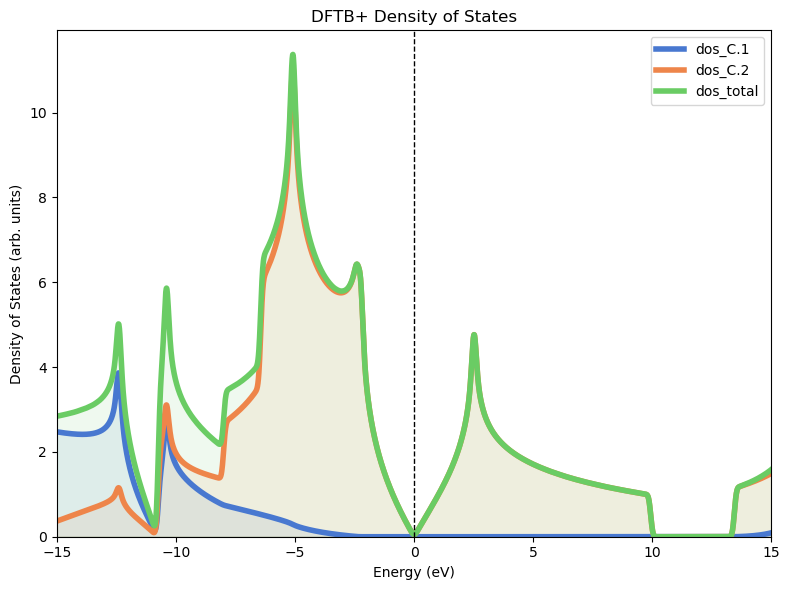

<Figure size 640x480 with 0 Axes>

In [38]:
plot_dos(".", show_total_only=False)

Now we are going to continue for the electronic band structure calculation. First lets create a directory for the band structure calculation.

In [39]:
! mkdir bs
%cd bs

/home/di97fod/Desktop/courses/BioPhy/calculations/dos_bs/GO/dos/bs


For the electronic band structure calculation, we need `charges.bin` and optimized geometry file

In [40]:
! cp ../charges.bin .
! cp ../opt.gen .

In [41]:
%%writefile dftb_in.hsd

Geometry = GenFormat {
    <<< "opt.gen"
}

Hamiltonian = DFTB {
  Scc = Yes
  ReadInitialCharges = Yes
  MaxSCCIterations = 1
  SccTolerance = 1e-5
  SlaterKosterFiles = Type2FileNames {
    Prefix = "../../../../../parameters/mio-1-1/"
    Separator = "-"
    Suffix = ".skf"
  }
MaxAngularMomentum {
    C = "p"
}
KPointsAndWeights = KLines {
 1    0.0  0.0  0.0                 # Gamma
 15    0.33333333  0.66666666 0.0    # K
 15    0.5  0.0  0.0                 # M
 15    0.0  0.0  0.0                 # Gamma
}
}


ParserOptions {
  ParserVersion = 12
}

Writing dftb_in.hsd


Let's run the calculation

In [42]:
! dftb+ > graphene_bs.log

We again convert `band.out` into `.dat` file in order to post process

In [43]:
! dp_bands band.out band

And now let's plot the band structure of 4x4 monolayer graphene at path Γ-K-M-Γ

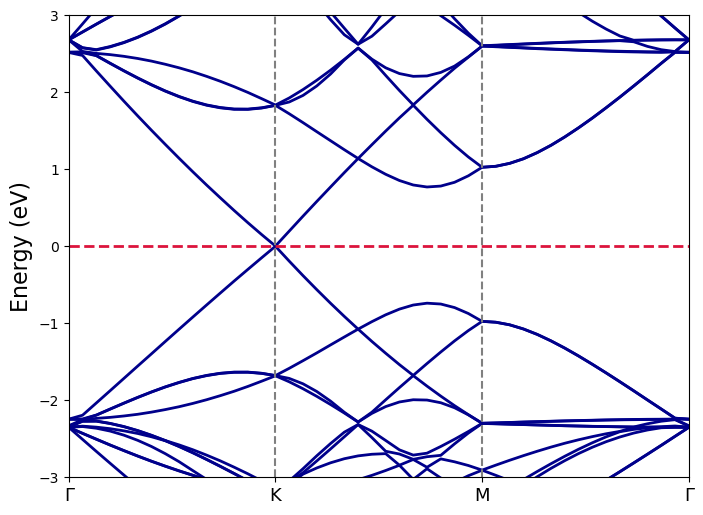

In [44]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("band_tot.dat")
k_points = data[:, 0]
bands = data[:, 1:] + 4.67

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for i in range(bands.shape[1]):
    ax.plot(k_points, bands[:, i], color='darkblue', linewidth=2)

ax.axhline(0, color="crimson", linestyle="--", linewidth=2)

for i in [16, 31]:
    plt.plot([i, i], [-3, 3], color='gray', linestyle='--')

ax.set_ylim(-3, 3)
ax.set_xlim(1, 46)

_ = ax.set_xticks([1, 16, 31, 46])
_ = ax.set_xticklabels(['Γ', 'K', 'M', 'Γ'], fontsize=13)

_ = ax.set_ylabel('Energy (eV)', fontsize=16)